In [1]:
# import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
import scipy.io

## Pre-Processing

#### Deleting Wav File to Save Space and Combine Folders Across Days

In [ ]:
train_bird = "/home/george-vengrovski/Documents/canary_song_detector/USA5207"
test_bird =  "/home/george-vengrovski/Documents/canary_song_detector/USA5199"

if os.path.exists(train_bird + "/joined_trained") == False:
    os.mkdir(train_bird + "/joined_trained")
if os.path.exists(test_bird + "/joined_test") == False:
    os.mkdir(test_bird + "/joined_test")

train_folders = os.listdir(train_bird)
test_folders = os.listdir(test_bird)


dst_trained = train_bird + "/joined_trained"
dst_test = test_bird + "/joined_test"

for folder in train_folders:
    if folder == "joined_trained":
        continue 

    files = os.listdir(os.path.join(train_bird, folder))
    
    for file in files:
        if file.endswith('.wav'):
            os.remove(os.path.join(train_bird, folder, file))
        else:
            for matrix in os.listdir(os.path.join(train_bird, folder, file)):
                src = os.path.join(train_bird, folder, file, matrix)
                shutil.copy(src, dst_trained)

for folder in test_folders:
    if folder == "joined_test":
        continue 

    files = os.listdir(os.path.join(test_bird, folder))
    
    for file in files:
        if file.endswith('.wav'):
            os.remove(os.path.join(test_bird, folder, file))
        else:
            for matrix in os.listdir(os.path.join(test_bird, folder, file)):
                src = os.path.join(test_bird, folder, file, matrix)
                shutil.copy(src, dst_test)

#### Test and Train Split

In [ ]:
split = 0.8
true_root_dir = "/home/george-vengrovski/Documents/canary_song_detector"
train_dir = os.path.join(true_root_dir, "train/")
test_dir = os.path.join(true_root_dir, "test/")

shutil.copytree(dst_trained, train_dir)
shutil.copytree(dst_test, test_dir)

#### Dataloader

In [ ]:
class DetectorDataClass():
    def __init__(self, dir, spec=513):
        self.data = []
        self.spec = spec

        for file in os.listdir(dir):
            self.data.append(os.path.join(dir, file))

    def __getitem__(self, index):
        data = self.data[index]
        mat_data = scipy.io.loadmat(data)
        mat_data = mat_data["song_data"]
        mat_data = mat_data[0][0]

        arr1 = mat_data[0]
        arr2 = mat_data[1]

        # beware if spec shape changes, this might cause error
        if arr1.shape[0] == self.spec:
            spec = torch.Tensor(arr1)
            raw_labels = torch.Tensor(arr2).int()
        else:
            spec = torch.Tensor(arr2)
            raw_labels = torch.Tensor(arr1).int()

        if raw_labels.shape == (0,0):
            song = False
        else:
            song = True

        # labels will be the same length as the song, but it will be filled with 1s between indcies of start and stops
        labels = torch.zeros(size=(spec.shape[1],))
        if song == True:
            num_entries = raw_labels.shape[0]
            for i in range(num_entries):
                if i % 2 == 0:
                    labels[raw_labels[i]:raw_labels[i+1]].fill_(1)
        
        spec = spec.unsqueeze(0)
        
        return spec, labels, song

    def __len__(self):
        return len(self.data) 

def collate_fn(batch):
    # Extract sequences and labels
    sequences = [x[0] for x in batch]
    labels = [x[1] for x in batch]
    
    # Find the max length for padding
    max_len_spec = max([s.size(2) for s in sequences])
    max_len_labels = max([l.size(0) for l in labels])
    
    # Pad each sequence to max length
    sequences_padded = []
    for s in sequences:
        pad_size = max_len_spec - s.size(2)
        sequences_padded.append(F.pad(s, (0, pad_size)))
    
    # Pad each label to max length
    labels_padded = []
    for l in labels:
        pad_size = max_len_labels - l.size(0)
        labels_padded.append(F.pad(l, (0, pad_size)))
    
    # Convert lists to tensors
    sequences_padded = torch.stack(sequences_padded)
    labels_padded = torch.stack(labels_padded)
    
    # Get the song flags
    songs = [x[2] for x in batch]
    songs = torch.Tensor(songs)
    
    return sequences_padded, labels_padded, songs

train_dir = "/home/george-vengrovski/Documents/canary_song_detector/train"
test_dir = "/home/george-vengrovski/Documents/canary_song_detector/test"

train_dataset = DetectorDataClass(train_dir)
test_dataset = DetectorDataClass(test_dir)
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=True, collate_fn=collate_fn)

In [185]:
class aviaBERT(nn.Module):
    def __init__(self, d_transformer, nhead_transformer, embedding_dim, num_labels, tau=0.1, dropout=0.1, transformer_layers=3,dim_feedforward=512):
        super(aviaBERT, self).__init__()
        self.tau = tau
        self.num_labels = num_labels
        self.dropout = dropout

        # TweetyNet Front End
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5, 5), stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=(8, 1), stride=(8, 1))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(5, 5), stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=(8, 1), stride=(8, 1))

        # Positional Encoding
        self.pos_conv1 = nn.Conv1d(d_transformer, d_transformer, kernel_size=3, padding=1, dilation=1)
        self.pos_conv2 = nn.Conv1d(d_transformer, d_transformer, kernel_size=3, padding=2, dilation=2)

        # transformer
        self.transformerProjection = nn.Linear(64, d_transformer)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_transformer, nhead=nhead_transformer, batch_first=True, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=transformer_layers)
        self.transformerDeProjection = nn.Linear(d_transformer, embedding_dim)
        self.onedconv = nn.Conv1d(embedding_dim, 1, kernel_size=31, stride=1, padding=15)

    def convolutional_positional_encoding(self, x):
        pos = F.relu(self.pos_conv1(x))
        pos = F.relu(self.pos_conv2(pos))
        return pos

    def feature_extractor_forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.flatten(1,2)
        return x

    def transformer_forward(self, x):
        # project the input to the transformer dimension
        x = x.permute(0,2,1)
        x = self.transformerProjection(x)
        x = x.permute(0,2,1)

        # add convolutional positional encoding
        pos_enc = self.convolutional_positional_encoding(x)
        x = x + pos_enc
        x = x.permute(0,2,1)
        x = self.transformer_encoder(x)
        x = self.transformerDeProjection(x)
        return x

    def forward(self, x):
        x = self.feature_extractor_forward(x)
        x = self.transformer_forward(x)
        x = x.permute(0,2,1)
        x = self.onedconv(x)
        x = x.permute(0,2,1)
        return x

    def BCE_loss(self, y_pred, y_true, weights, too_small=50, scaling_factor=.0001):
        # Convert y_pred to binary tensor for > 0.5 and < 0.5
        binary_pred_over_half = (y_pred > 0.5).float()
        binary_pred_under_half = (y_pred < 0.5).float()

        # Define a kernel of size too_small with all ones.
        kernel = torch.ones(too_small).to(y_pred.device)

        # Perform 1D convolution for > 0.5.
        conv_result_over_half = F.conv1d(binary_pred_over_half.unsqueeze(1), kernel.view(1,1,-1), padding=too_small-1).squeeze(1)
        
        # Perform 1D convolution for < 0.5.
        conv_result_under_half = F.conv1d(binary_pred_under_half.unsqueeze(1), kernel.view(1,1,-1), padding=too_small-1).squeeze(1)

        # A mask for regions of > 0.5 that are not continuous.
        non_continuous_mask_over_half = (conv_result_over_half < too_small) & (conv_result_over_half > 0)

        # A mask for regions of < 0.5 that are not continuous.
        non_continuous_mask_under_half = (conv_result_under_half < too_small) & (conv_result_under_half > 0)

        # Find the actual indices for > 0.5.
        non_continuous_indices_over_half = torch.nonzero(non_continuous_mask_over_half).squeeze()
        non_continuous_indices_over_half = non_continuous_indices_over_half.flatten()
        count_non_continuous_over_half = (non_continuous_indices_over_half > -1).sum().item()
        
        # Find the actual indices for < 0.5.
        non_continuous_indices_under_half = torch.nonzero(non_continuous_mask_under_half).squeeze()
        non_continuous_indices_under_half = non_continuous_indices_under_half.flatten()
        count_non_continuous_under_half = (non_continuous_indices_under_half > -1).sum().item()

        # Expand weights tensor to have the same shape as y_pred
        weights = weights.unsqueeze(dim=1)
        weights = weights.expand(weights.shape[0], y_pred.shape[1]).to(y_pred.device)

        loss_fn = torch.nn.BCEWithLogitsLoss(weight=weights)
        loss = loss_fn(input = y_pred, target = y_true)
        
        # Combine the penalties for regions over and under 0.5
        total_penalty = count_non_continuous_over_half + count_non_continuous_under_half

        return loss * (1 + total_penalty * scaling_factor)

In [186]:
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

def detailed_count_parameters(model):
    """Print details of layers with the number of trainable parameters in the model."""
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params += param
        # print(f"Layer: {name} | Parameters: {param:,} | Shape: {list(parameter.shape)}")
    print(f"\nTotal Trainable Parameters: {total_params:,}")

epochs = 15
learning_rate = 1e-5
max_batches = 10  # maximum number of batches per epoch
balance_weight = 4.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_list = []
model = aviaBERT(d_transformer=64, nhead_transformer=8, embedding_dim=8, num_labels=1, tau=0.1, dropout=0.3)
detailed_count_parameters(model)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)


Total Trainable Parameters: 363,481


In [187]:
def sum_squared_weights(model):
    sum_of_squares = sum(torch.sum(p ** 2) for p in model.parameters())
    return sum_of_squares

def frame_error_rate(y_pred, y_true):
    """
    Compute the frame error rate.
    y_pred: Tensor of shape (batch_size, time_steps) - typically the output of a softmax
    y_true: Tensor of shape (batch_size, time_steps) - ground truth labels
    Returns the frame error rate.
    """
    y_pred = F.sigmoid(y_pred)
    y_pred = torch.round(y_pred)
    mismatches = (y_pred != y_true)
    error = mismatches.sum() / y_true.size(0) / y_true.size(1)
    return error * 100  # return error as percentage

# Modify the validation function to also compute and return the frame error rate
def validate_model(model, test_loader):
    model.eval()
    total_val_loss = 0
    total_frame_error = 0
    num_val_batches = 0
    with torch.no_grad():
        for i, (spec, label, song) in enumerate(test_loader):
            if i > 100:
              break
            spec = spec.to(device)
            label = label.to(device)

            output = model.forward(spec)

            # weight True samples higher in loss function because there are less of them 
            weights = torch.ones(size=(song.shape[0],), requires_grad=True).to(device)
            weights = torch.where(song == True, 4.0, 1.0)

            loss = model.BCE_loss(y_pred = output.squeeze(2), y_true=label, weights=weights)

            total_frame_error += frame_error_rate(y_pred = output.squeeze(2), y_true=label).item()

            total_val_loss += loss.item()
            num_val_batches += 1

    return total_val_loss / num_val_batches, total_frame_error / num_val_batches

initial_val_loss, initial_frame_error = validate_model(model, test_loader)
print(f'Initial Validation Loss: {initial_val_loss:.2e}, Initial Frame Error Rate: {initial_frame_error:.2f}%')

loss_list = []
val_loss_list = []

for epoch in range(epochs):
    total_loss = 0
    num_batches = 0

    # Training Loop
    model.train()
    for i, (spec, label, song) in enumerate(train_loader):
        if i > 100:
          break
        spec = spec.to(device)
        label = label.to(device)

        output = model.forward(spec)        
        # weight True samples higher in loss function because there are less of them 
        weights = torch.ones(size=(song.shape[0],), requires_grad=True).to(device)
        weights = torch.where(song == True, 4.0, 1.0)
        loss = model.BCE_loss(y_pred = output.squeeze(2), y_true=label, weights=weights)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    avg_train_loss = total_loss / num_batches
    loss_list.append(avg_train_loss)

    avg_val_loss, avg_frame_error = validate_model(model, test_loader)
    val_loss_list.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.2e}, Validation Loss: {avg_val_loss:.2e}, Frame Error Rate: {avg_frame_error:.2f}%')

# print loss curve
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.legend()
plt.show()

print(f"final loss {loss_list[-1]}")

Initial Validation Loss: 9.79e-01, Initial Frame Error Rate: 4.51%


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.25 GiB (GPU 0; 23.64 GiB total capacity; 15.56 GiB already allocated; 1.66 GiB free; 18.21 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

tensor(1.)


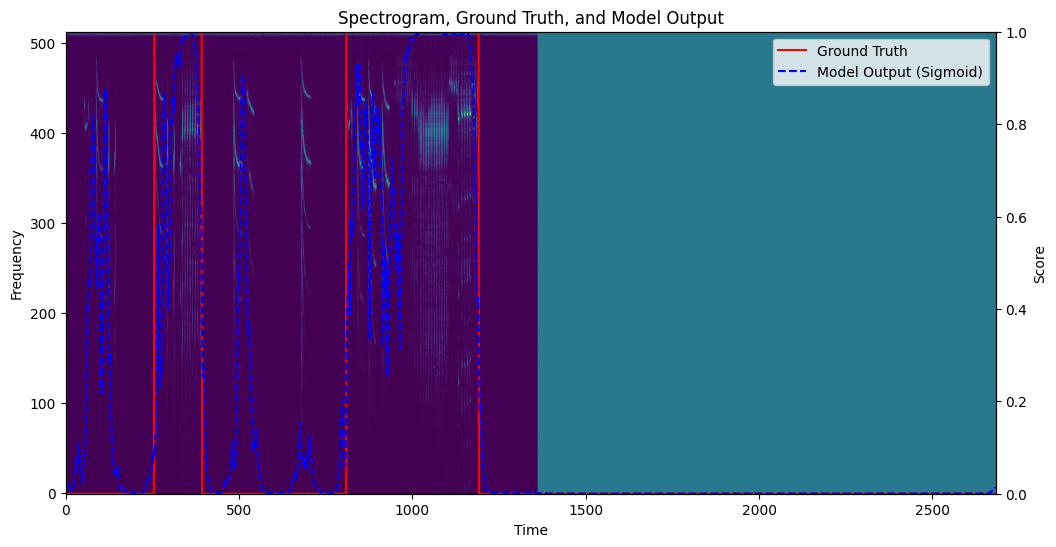

In [179]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

spec, labels, song = next(iter(test_loader))
output = model(spec.to(device))

# Apply the sigmoid function to the model's output
sigmoid_output = F.sigmoid(output[0]).detach().cpu().numpy()

# Print the song name or details
print(song[0])

# Create a figure and axis for the spectrogram
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the spectrogram
ax1.imshow(spec[0, 0], aspect='auto', origin='lower', cmap='viridis')
ax1.set_xlabel('Time')
ax1.set_ylabel('Frequency')
ax1.set_title('Spectrogram, Ground Truth, and Model Output')

# Create a twin axis for the labels and the output
ax2 = ax1.twinx()

# Set y-axis limits for scores between 0 and 1
ax2.set_ylim([0, 1])

# Plot the ground truth (labels)
ax2.plot(labels[0], color='red', label='Ground Truth')

# Plot the sigmoid-transformed model's output
ax2.plot(sigmoid_output, color='blue', linestyle='dashed', label='Model Output (Sigmoid)')

# Set labels for the twin axis
ax2.set_ylabel('Score')

# Add a legend to make things clear
ax2.legend(loc='upper right')

# Display the plot
plt.show()
